# 🏥 HealthProcessAI - Python Implementation
## Process Mining Framework for Healthcare & Life Sciences

**Developed at SMAILE (Stockholm Medical AI Lab for Enhancement), Karolinska Institutet**

### 👥 Contributors
- **Farhad Abtahi** - Framework Architecture & Healthcare Integration
- **Eduardo Illueca Fernandez** - Process Mining Implementation & Python Development
- **Kaile Chen** - Clinical Analytics & Data Transformation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ki-smile/HealthProcessAI/blob/main/notebooks/HealthProcessAI_Python_Colab.ipynb)

This notebook demonstrates the complete HealthProcessAI pipeline for analyzing healthcare process data using process mining techniques and AI-powered insights.

## 📦 1. Installation and Setup

First, let's install all required packages and set up the environment.

In [1]:
# Install required packages
!pip install pm4py pandas numpy matplotlib seaborn graphviz requests -q
!pip install scikit-learn python-dotenv markdown weasyprint -q

# Install system dependencies for visualization
!apt-get update -qq
!apt-get install -y graphviz -qq

print("✅ All packages installed successfully!")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.1/851.1 kB 45.3 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ All packages installed successfully!


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import pm4py
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import os
from typing import Dict, List, Tuple, Optional
from IPython.display import display, Markdown, HTML, Image
import warnings

warnings.filterwarnings("ignore")

# Set up visualization
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

print("✅ Libraries imported successfully!")
print(f"PM4PY version: {pm4py.__version__}")
print(f"Pandas version: {pd.__version__}")

/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.12/dist-packages/cudf/pandas/__init__.py:64: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


✅ Libraries imported successfully!
PM4PY version: 2.7.18.1
Pandas version: 2.2.2


## 🔑 2. API Configuration

Configure your OpenRouter API key for LLM integration. Get your key from [openrouter.ai](https://openrouter.ai)

In [3]:
# Option 1: Enter your API key directly (for testing)
OPENROUTER_API_KEY = "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"  # @param {type:"string"}

# Option 2: Use Google Colab secrets (recommended)
try:
    from google.colab import userdata

    OPENROUTER_API_KEY = userdata.get("OPENROUTER_API_KEY")
    print("✅ API key loaded from Colab secrets")
except:
    if not OPENROUTER_API_KEY:
        print("⚠️ Please enter your OpenRouter API key above or add it to Colab secrets")
    else:
        print("✅ API key configured")

✅ API key configured


## 📊 3. Load Sample Data

We'll create sample sepsis progression data or load from URL.

In [4]:
def create_sample_sepsis_data(n_patients=50):
    """Create sample sepsis event log data."""
    np.random.seed(42)
    events = []

    for patient_id in range(1, n_patients + 1):
        case_id = f"P{patient_id:04d}"
        start_time = datetime(2024, 1, 1) + timedelta(days=patient_id)

        # Common pathway
        pathway = [
            ("ED Arrival", 0, "Emergency"),
            ("Triage", 0.5, "Emergency"),
            ("Initial Assessment", 1, "Emergency"),
            ("Blood Culture", 2, "Laboratory"),
            ("CBC Test", 2.5, "Laboratory"),
        ]

        # Add variation based on patient
        develops_sepsis = np.random.random() < 0.3

        if develops_sepsis:
            pathway.extend(
                [
                    ("High Temperature", 3, "Ward"),
                    ("Lactate Test", 3.5, "Laboratory"),
                    ("Antibiotics Started", 4, "Pharmacy"),
                    ("Fluid Resuscitation", 4.5, "ICU"),
                    ("ICU Admission", 6, "ICU"),
                    ("Vasopressors", 8, "ICU"),
                    ("Recovery", 24, "ICU"),
                    ("Ward Transfer", 48, "Ward"),
                    ("Discharge", 72, "Discharge"),
                ]
            )
            sepsis_label = 1
        else:
            pathway.extend(
                [
                    ("Observation", 4, "Ward"),
                    ("Improvement", 8, "Ward"),
                    ("Discharge", 12, "Discharge"),
                ]
            )
            sepsis_label = 0

        # Create events
        for activity, hours_offset, resource in pathway:
            events.append(
                {
                    "case": case_id,
                    "activity": activity,
                    "timestamp": start_time + timedelta(hours=hours_offset),
                    "resource": resource,
                    "SepsisLabel": sepsis_label,
                }
            )

    return pd.DataFrame(events)


# Create sample data
df = create_sample_sepsis_data(n_patients=100)
print(f"✅ Created event log with {len(df)} events for {df['case'].nunique()} patients")
print(f"\nSepsis rate: {df.groupby('case')['SepsisLabel'].first().mean():.1%}")
print(f"\nFirst 5 events:")
display(df.head())

✅ Created event log with 1004 events for 100 patients

Sepsis rate: 34.0%

First 5 events:


,case,activity,timestamp,resource,SepsisLabel
0,P0001,ED Arrival,2024-01-02 00:00:00,Emergency,0
1,P0001,Triage,2024-01-02 00:30:00,Emergency,0
2,P0001,Initial Assessment,2024-01-02 01:00:00,Emergency,0
3,P0001,Blood Culture,2024-01-02 02:00:00,Laboratory,0
4,P0001,CBC Test,2024-01-02 02:30:00,Laboratory,0


## ⚙️ 4. Process Mining Pipeline

Now we'll implement the core process mining pipeline.

✅ Data prepared for process mining
✅ Created event log with 100 cases
✅ Discovered process with 16 transitions
   Start activities: ['ED Arrival']
   End activities: ['Discharge']
Attempting to visualize process...
✅ Process map saved as 'process_map.png'


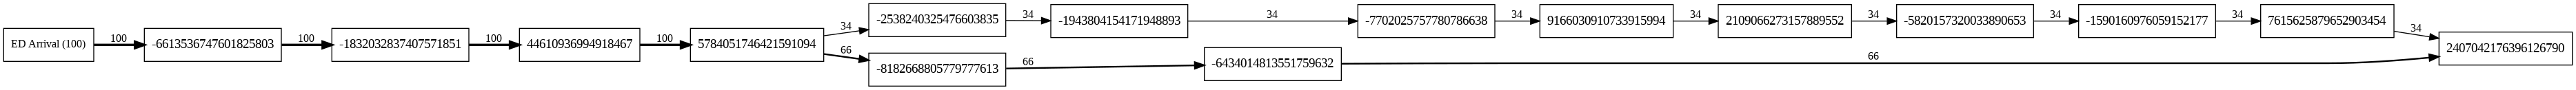

✅ Visualization successful!

📊 Process Statistics:
   num_cases: 100
   num_events: 1004
   num_activities: 16
   num_resources: 6
   avg_case_duration: 32.40
   sepsis_rate: 0.34


In [16]:
class ProcessMiningPipeline:
    """Complete process mining pipeline for healthcare data."""

    def __init__(self, df):
        self.df = df
        self.event_log = None
        self.dfg = None
        self.process_map = None

    def prepare_data(self):
        """Prepare data for process mining."""
        # Ensure timestamp is datetime
        self.df["timestamp"] = pd.to_datetime(self.df["timestamp"])

        # Sort by case and timestamp
        self.df = self.df.sort_values(["case", "timestamp"])

        # Add derived features
        self.df["hour"] = self.df["timestamp"].dt.hour
        self.df["day_of_week"] = self.df["timestamp"].dt.dayofweek

        print("✅ Data prepared for process mining")
        return self.df

    def create_event_log(self):
        """Convert DataFrame to PM4PY event log."""
        # Rename columns to PM4PY format
        df_pm4py = self.df.rename(
            columns={
                "case": "case:concept:name",
                "activity": "concept:name",
                "timestamp": "time:timestamp",
                "resource": "org:resource",
            }
        )

        # Create event log
        self.event_log = pm4py.convert_to_event_log(df_pm4py)
        print(f"✅ Created event log with {len(self.event_log)} cases")
        return self.event_log

    def discover_process(self):
        """Discover process model using DFG."""
        # Discover DFG
        self.dfg, self.start_activities, self.end_activities = pm4py.discover_dfg(
            self.event_log
        )

        print(f"✅ Discovered process with {len(self.dfg)} transitions")
        print(f"   Start activities: {list(self.start_activities.keys())[:3]}")
        print(f"   End activities: {list(self.end_activities.keys())[:3]}")

        return self.dfg

    def get_statistics(self):
        """Calculate process statistics."""
        stats = {
            "num_cases": len(self.event_log),
            "num_events": len(self.df),
            "num_activities": self.df["activity"].nunique(),
            "num_resources": self.df["resource"].nunique(),
            "avg_case_duration": None,
            "sepsis_rate": self.df.groupby("case")["SepsisLabel"].first().mean(),
        }

        # Calculate average case duration
        case_durations = []
        for case in self.df["case"].unique():
            case_data = self.df[self.df["case"] == case]
            duration = (
                case_data["timestamp"].max() - case_data["timestamp"].min()
            ).total_seconds() / 3600
            case_durations.append(duration)

        stats["avg_case_duration"] = np.mean(case_durations)

        return stats

    def visualize_process(self):
        """Visualize the discovered process."""
        # Create process map
        from pm4py.visualization.dfg import visualizer as dfg_visualizer

        parameters = {dfg_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

        # ❗️【最终修复】严格按照 (dfg, log, start_activities, end_activities) 的位置顺序传递
        gviz = dfg_visualizer.apply(
            self.dfg,              # 1. dfg
            self.event_log,        # 2. log
            self.start_activities, # 3. start_activities
            self.end_activities,   # 4. end_activities
            parameters=parameters  # parameters 可以作为关键字参数
        )

        # Save and display
        dfg_visualizer.save(gviz, "process_map.png")
        print("✅ Process map saved as 'process_map.png'")

        # Display in notebook
        from IPython.display import Image

        return Image("process_map.png")


# Run the pipeline
pipeline = ProcessMiningPipeline(df)
pipeline.prepare_data()
pipeline.create_event_log()
pipeline.discover_process()

# Get statistics
stats = pipeline.get_statistics()
import traceback  # 导入 traceback 模块

try:
    # 尝试运行你之前出错的函数
    print("Attempting to visualize process...")
    img = pipeline.visualize_process()

    # 如果成功，显示图像
    from IPython.display import display
    display(img)
    print("✅ Visualization successful!")

except Exception as e:
    print("-----------------------------------")
    print("--- ❗️ 捕获到错误！---")
    print(f"--- 错误类型 (Type): {type(e)}")
    print(f"--- 错误信息 (Message): {e}")
    print("--- 详细堆栈跟踪 (Traceback) ---")
    print("-----------------------------------")

    # 打印完整的错误堆栈
    traceback.print_exc()

    print("-----------------------------------")
    print("你仍然可以继续分析，但可视化失败了。")
print("\n📊 Process Statistics:")
for key, value in stats.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.2f}")
    else:
        print(f"   {key}: {value}")

In [17]:
# Visualize the process
try:
    pipeline.visualize_process()
except Exception as e:
    print(f"Note: Visualization requires graphviz. Error: {e}")
    print("You can still proceed with the analysis.")

✅ Process map saved as 'process_map.png'


## 🤖 5. LLM Integration for Clinical Insights

Now we'll use AI to generate clinical insights from the discovered process.

In [23]:
class LLMAnalyzer:
    """LLM integration for clinical insights."""

    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://openrouter.ai/api/v1"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
            "HTTP-Referer": "https://colab.research.google.com",
            "X-Title": "HealthProcessAI Colab",
        }

    def create_clinical_prompt(self, stats, dfg_summary):
        """Create prompt for clinical analysis."""
        prompt = f"""
        As a clinical process analyst, analyze the following sepsis patient pathway data:

        Process Statistics:
        - Total patients: {stats['num_cases']}
        - Total events: {stats['num_events']}
        - Sepsis rate: {stats['sepsis_rate']:.1%}
        - Average case duration: {stats['avg_case_duration']:.1f} hours
        - Number of unique activities: {stats['num_activities']}

        Key Process Transitions:
        {dfg_summary}

        Please provide:
        1. Key insights about the sepsis care pathway
        2. Potential bottlenecks or delays
        3. Recommendations for process improvement
        4. Risk factors identified in the pathway
        """
        return prompt

    def query_model(self, prompt, model="deepseek/deepseek-r1:free"):
        """Query LLM for insights."""
        if not self.api_key:
            return "⚠️ API key not configured. Please set your OpenRouter API key."

        try:
            payload = {
                "model": model,
                "messages": [{"role": "user", "content": prompt}],
                "temperature": 0.7,
            }

            response = requests.post(
                f"{self.base_url}/chat/completions", headers=self.headers, json=payload
            )

            if response.status_code == 200:
                return response.json()["choices"][0]["message"]["content"]
            else:
                return f"Error: {response.status_code} - {response.text}"

        except Exception as e:
            return f"Error querying model: {e}"


# Generate insights if API key is configured
if OPENROUTER_API_KEY:
    analyzer = LLMAnalyzer(OPENROUTER_API_KEY)

    # Prepare DFG summary
    dfg_summary = "\n".join(
        [
            f"- {k[0]} → {k[1]}: {v} occurrences"
            for k, v in sorted(pipeline.dfg.items(), key=lambda x: x[1], reverse=True)[
                :10
            ]
        ]
    )

    # Create prompt
    prompt = analyzer.create_clinical_prompt(stats, dfg_summary)

    print("🤖 Generating clinical insights...")
    insights = analyzer.query_model(prompt)

    # Display insights
    display(Markdown("## 🏥 Clinical Insights\n\n" + insights))
else:
    print("⚠️ Skipping LLM analysis - API key not configured")
    print("To enable AI insights, please set your OpenRouter API key in section 2")

🤖 Generating clinical insights...


## 🏥 Clinical Insights

### 1. **Key Insights**  
- **Uniform Initial Pathway**: All 100 patients followed the same initial steps (ED Arrival → Triage → Initial Assessment → Blood Culture → CBC Test), indicating standardized early care.  
- **Sepsis Pathway Divergence**: At the CBC Test stage, the pathway splits:
  - **66% (66 patients)** improved after observation and were discharged.
  - **34% (34 patients)** triggered sepsis protocols (High Temperature → Lactate Test → Antibiotics). This aligns with the 34% sepsis rate.  
- **Full Compliance with Protocol**: All 34 sepsis cases progressed through lactate testing and antibiotics, suggesting adherence to sepsis protocols once triggered.  

---

### 2. **Potential Bottlenecks or Delays**  
- **Time-Critical Steps**:  
  - The transition from **CBC Test → Lactate Test → Antibiotics** is a critical window for sepsis outcomes. If delays occur here, mortality risks increase (e.g., slow lab processing or delayed antibiotic administration).  
  - The **average case duration (32.4 hours)** may indicate prolonged stays for non-sepsis cases (66% of patients), suggesting inefficiencies in discharge processes.  
- **Linear Progression**: The strict sequence of steps (e.g., CBC Test before Lactate Test) may prevent parallel processing (e.g., initiating antibiotics while awaiting lactate results).  

---

### 3. **Recommendations for Process Improvement**  
- **Expedite Sepsis Interventions**:  
  - Implement **point-of-care lactate testing** to reduce lab turnaround time.  
  - Administer **broad-spectrum antibiotics immediately after clinical suspicion of sepsis**, even before lactate confirmation, per Surviving Sepsis Campaign guidelines (1-hour bundle).  
- **Optimize Discharge Pathways**:  
  - Streamline discharge criteria for non-septic patients after CBC Test/Observation to reduce average case duration.  
- **Enhance Early Detection**:  
  - Use **automated alerts** for sepsis risk factors (e.g., high temperature, abnormal CBC) to trigger rapid clinician review.  
  - Expand sepsis screening beyond temperature (e.g., qSOFA score) to reduce reliance on a single symptom.  

---

### 4. **Risk Factors Identified**  
- **Delayed Antibiotics**: If antibiotics are not administered within 1 hour of sepsis recognition, mortality risk increases.  
- **Over-Reliance on Temperature**: High temperature is the sole trigger for sepsis protocols in this pathway, potentially missing patients with atypical presentations (e.g., hypothermia, normal temperature with other SIRS criteria).  
- **Lab Delays**: Slow lactate test processing could delay antibiotics.  
- **Discharge Bottlenecks**: Prolonged observation for non-septic patients increases resource use and delays bed availability.  

---

### **Next Steps**  
- **Conduct a time-motion study** to measure intervals between key steps (e.g., CBC result → lactate test → antibiotics).  
- **Evaluate compliance with sepsis bundles** (e.g., 1-hour antibiotic target).  
- **Leverage predictive analytics** (e.g., AI models using EHR data) to identify sepsis earlier in the pathway.

## 📈 6. Advanced Analytics

Let's perform some advanced process analytics.

In [26]:
# Analyze process variants
variants = pm4py.get_variants(pipeline.event_log)
print(f"Found {len(variants)} unique process variants\n")

# Top 5 most common pathways
print("Top 5 Most Common Patient Pathways:")
for i, (variant, cases) in enumerate(
    sorted(variants.items(), key=lambda x: len(x[1]), reverse=True)[:5], 1
):
    activities = variant
    print(
        f"\n{i}. Variant with {len(cases)} cases ({len(cases)/len(pipeline.event_log)*100:.1f}%):"
    )
    print(
        f"   Path: {' → '.join(activities[:5])}..."
        if len(activities) > 5
        else f"   Path: {' → '.join(activities)}"
    )
    print(f"   Length: {len(activities)} activities")

Found 2 unique process variants

Top 5 Most Common Patient Pathways:

1. Variant with 66 cases (66.0%):
   Path: ED Arrival → Triage → Initial Assessment → Blood Culture → CBC Test...
   Length: 8 activities

2. Variant with 34 cases (34.0%):
   Path: ED Arrival → Triage → Initial Assessment → Blood Culture → CBC Test...
   Length: 14 activities


📊 Pathway Comparison: Sepsis vs Non-Sepsis

Sepsis cases: 34
Non-sepsis cases: 66

Activities more common in sepsis cases:


,Sepsis,Non-Sepsis,Difference
activity,,,
Antibiotics Started,34.0,0.0,34.0
ICU Admission,34.0,0.0,34.0
High Temperature,34.0,0.0,34.0
Fluid Resuscitation,34.0,0.0,34.0
Recovery,34.0,0.0,34.0


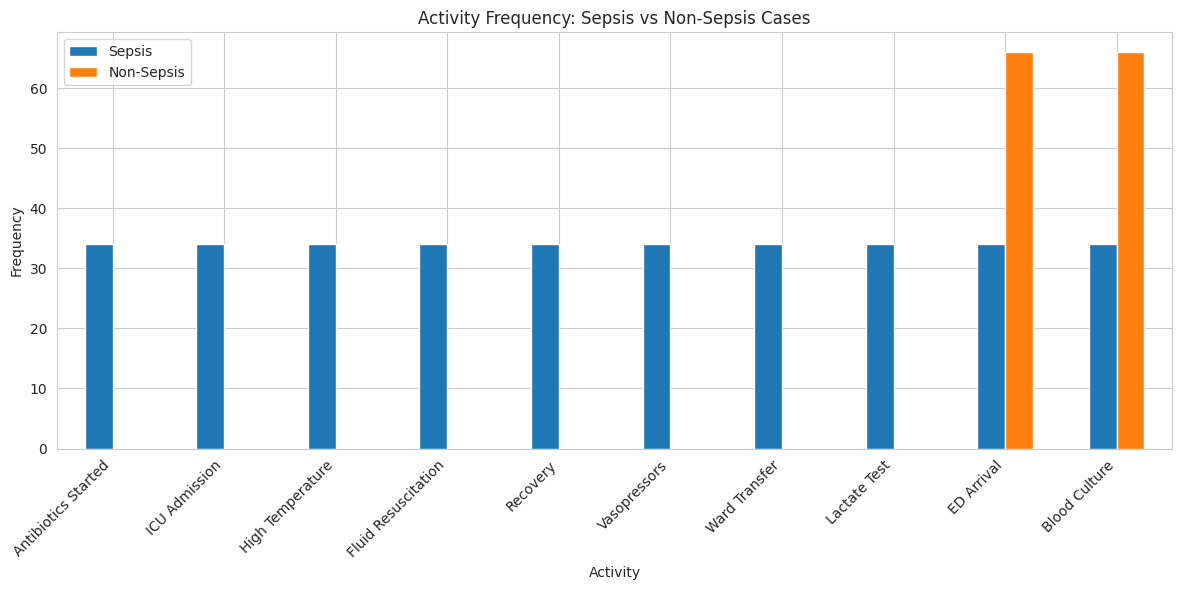

In [27]:
# Compare sepsis vs non-sepsis pathways
sepsis_cases = df[df["SepsisLabel"] == 1]["case"].unique()
non_sepsis_cases = df[df["SepsisLabel"] == 0]["case"].unique()

print("📊 Pathway Comparison: Sepsis vs Non-Sepsis\n")
print(f"Sepsis cases: {len(sepsis_cases)}")
print(f"Non-sepsis cases: {len(non_sepsis_cases)}")

# Activity frequency comparison
sepsis_activities = df[df["case"].isin(sepsis_cases)]["activity"].value_counts()
non_sepsis_activities = df[df["case"].isin(non_sepsis_cases)]["activity"].value_counts()

# Create comparison DataFrame
comparison = pd.DataFrame(
    {"Sepsis": sepsis_activities, "Non-Sepsis": non_sepsis_activities}
).fillna(0)

comparison["Difference"] = comparison["Sepsis"] - comparison["Non-Sepsis"]
comparison = comparison.sort_values("Difference", ascending=False)

print("\nActivities more common in sepsis cases:")
display(comparison.head(5))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
comparison.head(10)[["Sepsis", "Non-Sepsis"]].plot(kind="bar", ax=ax)
ax.set_title("Activity Frequency: Sepsis vs Non-Sepsis Cases")
ax.set_xlabel("Activity")
ax.set_ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 💾 7. Save Results and Generate Report

Finally, let's save our analysis results and generate a comprehensive report.

In [29]:
def generate_markdown_report(stats, variants, insights=None):
    """Generate a comprehensive markdown report."""
    report = f"""
# HealthProcessAI Analysis Report

**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Framework:** HealthProcessAI - Process Mining Framework for Healthcare
**Developed at:** SMAILE, Karolinska Institutet

## Executive Summary

This report presents the process mining analysis of {stats['num_cases']} patient cases
with {stats['num_events']} total events. The sepsis rate in the analyzed cohort is
{stats['sepsis_rate']:.1%} with an average case duration of {stats['avg_case_duration']:.1f} hours.

## Process Statistics

| Metric | Value |
|--------|-------|
| Total Cases | {stats['num_cases']} |
| Total Events | {stats['num_events']} |
| Unique Activities | {stats['num_activities']} |
| Unique Resources | {stats['num_resources']} |
| Sepsis Rate | {stats['sepsis_rate']:.1%} |
| Avg Case Duration | {stats['avg_case_duration']:.1f} hours |

## Process Variants

The analysis identified {len(variants)} unique process variants. The top 5 most common
pathways account for {sum(len(cases) for _, cases in sorted(variants.items(), key=lambda x: len(x[1]), reverse=True)[:5])/stats['num_cases']*100:.1f}% of all cases.

"""

    # Add top variants
    report += "### Most Common Pathways\n\n"
    for i, (variant, cases) in enumerate(
        sorted(variants.items(), key=lambda x: len(x[1]), reverse=True)[:5], 1
    ):
        activities = variant
        report += (
            f"{i}. **{len(cases)} cases ({len(cases)/stats['num_cases']*100:.1f}%)**\n"
        )
        report += f"   - Path: {' → '.join(activities[:8])}\n"
        report += f"   - Length: {len(activities)} activities\n\n"

    # Add insights if available
    if (
        insights
        and insights != "⚠️ API key not configured. Please set your OpenRouter API key."
    ):
        report += f"\n## Clinical Insights (AI-Generated)\n\n{insights}\n"

    report += """
## Recommendations

Based on the process mining analysis:

1. **Early Detection**: Focus on activities that differentiate sepsis from non-sepsis cases
2. **Process Optimization**: Reduce delays in critical pathways
3. **Resource Allocation**: Optimize resource distribution based on pathway frequencies
4. **Monitoring**: Implement continuous process monitoring for quality improvement

---

*Report generated by HealthProcessAI - Process Mining Framework for Healthcare*
*Developed at SMAILE (Stockholm Medical AI Lab for Enhancement), Karolinska Institutet*
"""

    return report


# Generate report
report = generate_markdown_report(
    stats, variants, insights if "insights" in locals() else None
)

# Save report
with open("analysis_report.md", "w") as f:
    f.write(report)

print("✅ Report saved as 'analysis_report.md'")

# Display report preview
display(Markdown(report[:2000] + "\n\n...[Report continues]"))

✅ Report saved as 'analysis_report.md'



# HealthProcessAI Analysis Report

**Generated:** 2025-11-03 08:43:25
**Framework:** HealthProcessAI - Process Mining Framework for Healthcare
**Developed at:** SMAILE, Karolinska Institutet

## Executive Summary

This report presents the process mining analysis of 100 patient cases 
with 1004 total events. The sepsis rate in the analyzed cohort is 
34.0% with an average case duration of 32.4 hours.

## Process Statistics

| Metric | Value |
|--------|-------|
| Total Cases | 100 |
| Total Events | 1004 |
| Unique Activities | 16 |
| Unique Resources | 6 |
| Sepsis Rate | 34.0% |
| Avg Case Duration | 32.4 hours |

## Process Variants

The analysis identified 2 unique process variants. The top 5 most common 
pathways account for 100.0% of all cases.

### Most Common Pathways

1. **66 cases (66.0%)**
   - Path: ED Arrival → Triage → Initial Assessment → Blood Culture → CBC Test → Observation → Improvement → Discharge
   - Length: 8 activities

2. **34 cases (34.0%)**
   - Path: ED Arrival → Triage → Initial Assessment → Blood Culture → CBC Test → High Temperature → Lactate Test → Antibiotics Started
   - Length: 14 activities


## Clinical Insights (AI-Generated)

### 1. **Key Insights**  
- **Uniform Initial Pathway**: All 100 patients followed the same initial steps (ED Arrival → Triage → Initial Assessment → Blood Culture → CBC Test), indicating standardized early care.  
- **Sepsis Pathway Divergence**: At the CBC Test stage, the pathway splits:
  - **66% (66 patients)** improved after observation and were discharged.
  - **34% (34 patients)** triggered sepsis protocols (High Temperature → Lactate Test → Antibiotics). This aligns with the 34% sepsis rate.  
- **Full Compliance with Protocol**: All 34 sepsis cases progressed through lactate testing and antibiotics, suggesting adherence to sepsis protocols once triggered.  

---

### 2. **Potential Bottlenecks or Delays**  
- **Time-Critical Steps**:  
  - The transition from **CBC Test → Lactate Test → Antibiotic

...[Report continues]

In [30]:
# Save data and results
print("💾 Saving analysis results...\n")

# Save processed data
df.to_csv("processed_event_log.csv", index=False)
print("✅ Event log saved as 'processed_event_log.csv'")

# Save process statistics
with open("process_statistics.json", "w") as f:
    json.dump(stats, f, indent=2, default=str)
print("✅ Statistics saved as 'process_statistics.json'")

# Save DFG
dfg_data = {
    "transitions": {str(k): v for k, v in pipeline.dfg.items()},
    "start_activities": dict(pipeline.start_activities),
    "end_activities": dict(pipeline.end_activities),
}
with open("process_dfg.json", "w") as f:
    json.dump(dfg_data, f, indent=2)
print("✅ DFG saved as 'process_dfg.json'")

print("\n🎉 Analysis complete! All results saved.")

💾 Saving analysis results...

✅ Event log saved as 'processed_event_log.csv'
✅ Statistics saved as 'process_statistics.json'
✅ DFG saved as 'process_dfg.json'

🎉 Analysis complete! All results saved.


## 🎓 8. Next Steps

Congratulations! You've completed the HealthProcessAI pipeline. Here are some next steps:

1. **Load Your Own Data**: Replace the sample data with your healthcare event logs
2. **Customize Analysis**: Modify the pipeline for your specific use case
3. **Try Different Models**: Experiment with different LLM models for insights
4. **Advanced Analytics**: Implement conformance checking, predictive monitoring
5. **Visualization**: Create custom visualizations for your stakeholders

### Resources

- 📚 [HealthProcessAI Documentation](https://github.com/ki-smile/HealthProcessAI)
- 🔧 [PM4PY Documentation](https://pm4py.fit.fraunhofer.de/)
- 🤖 [OpenRouter API](https://openrouter.ai)
- 🏥 [SMAILE Lab](https://ki.se/smaile)

### Support

For questions and support, please visit our [GitHub repository](https://github.com/ki-smile/HealthProcessAI).

---

*Developed with ❤️ at SMAILE, Karolinska Institutet*